# Custom preprocessing

Preprocessors in OpenSoundscape perform all of the preprocessing steps from loading a file from disk, up to providing a sample to the machine learning algorithm for training or prediction. These classes are used when (a) training a machine learning model in OpenSoundscape, or (b) making predictions with a machine learning model in OpenSoundscape. 

If you are already familiar with PyTorch, you might notice that Preprocessors take the place of, and are children of, PyTorch's Dataset classes to provide each sample to PyTorch as a Tensor.

Preprocessors are designed to be flexible and modular, so that each step of the preprocessing pipeline can be modified or removed. This notebook demonstrates:

- preparation of audio data to be used by a preprocessor
- how "Actions" are strung together into "Pipelines" to preprocess data
- modifying the parameters of actions
- turning Actions on and off
- modifying the order and contents of pipelines
- use of the `SpecPreprocessor` class, including examples of:
    * modifying audio and spectrogram parameters
    * changing the output image shape
    * changing the output type
    * turning augmentation on and off
    * modifying augmentation parameters
    * using the "overlay" augmentation
- writing custom preprocessors and actions

First, import the needed packages.

In [1]:
# Preprocessor classes are used to load, transform, and augment audio samples for use in a machine learing model
from opensoundscape.preprocess.preprocessors import SpecPreprocessor

#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
import subprocess

Set up plotting and some helper functions.

In [2]:
#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# helper function for displaying a sample as an image 
from opensoundscape.preprocess.utils import show_tensor

Set manual seeds for pytorch and python. These ensure the training results are reproducible. You probably don't want to do this when you actually train your model, but it's useful for debugging.

In [3]:
torch.manual_seed(0)
random.seed(0)

## Preparing audio data

### Download labeled audio files

The Kitzes Lab has created a small labeled dataset of short clips of American Woodcock vocalizations. You have two options for obtaining the folder of data, called `woodcock_labeled_data`:

1. Run the following cell to download this small dataset. These commands require you to have `tar` installed on your computer, as they will download and unzip a compressed file in `.tar.gz` format. 

2. Download a `.zip` version of the files by clicking [here](https://pitt.box.com/shared/static/m0cmzebkr5qc49q9egxnrwwp50wi8zu5.zip). You will have to unzip this folder and place the unzipped folder in the same folder that this notebook is in.

**Note**: Once you have the data, you do not need to run this cell again.

In [4]:
subprocess.run(['curl','https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz','-L', '-o','woodcock_labeled_data.tar.gz']) # Download the data
subprocess.run(["tar","-xzf", "woodcock_labeled_data.tar.gz"]) # Unzip the downloaded tar.gz file
subprocess.run(["rm", "woodcock_labeled_data.tar.gz"]) # Remove the file after its contents are unzipped

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     7    0     7    0     0      5      0 --:--:--  0:00:01 --:--:--    12
100 9499k  100 9499k    0     0  1844k      0  0:00:05  0:00:05 --:--:-- 3065k


CompletedProcess(args=['rm', 'woodcock_labeled_data.tar.gz'], returncode=0)

### Load dataframe of files and labels
We need a dataframe with file paths in the index, so we manipulate the included one_hot_labels.csv slightly:

In [5]:
# load one-hot labels dataframe
labels = pd.read_csv('./woodcock_labeled_data/one_hot_labels.csv').set_index('file')
# prepend the folder location to the file paths
labels.index = pd.Series(labels.index).apply(lambda f: './woodcock_labeled_data/'+f)
#inspect
labels.head()

present  absent
file                                                               
./woodcock_labeled_data/d4c40b6066b489518f8da83...        1       0
./woodcock_labeled_data/e84a4b60a4f2d049d73162e...        0       1
./woodcock_labeled_data/79678c979ebb880d5ed6d56...        1       0
./woodcock_labeled_data/49890077267b569e142440f...        1       0
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5...        1       0

## Intro to Preprocessors


Preprocessors prepare samples for use by machine learning algorithms by stringing together transformations called **Actions** into a **Pipeline**. The preprocessor sequentially applies to the sample each Action in the Pipeline. You can add, remove, and rearrange Actions from the pipeline and change the parameters of each Action.

CNNs in OpenSoundscape have an internal Preprocessor object which they use to generate samples during training, validation, and prediction. We can modify or overwrite the cnn model's preprocessor object if we want to change how it generates samples. 

The starting point for most preprocessors will be the `SpecPreprocessor` class, which loads audio files, creates spectrograms from the audio, performs various augmentations, and returns a pytorch Tensor. 

### Initialize preprocessor 

A Preprocessor draws samples from it's `.df` attribute which must be a very specific dataframe: 

- the index of the dataframe provides paths to audio samples
- the columns are the class names
- the values are 0 (absent/False) or 1 (present/True) for each sample and each class.

We also need to tell the preprocessor the duration (in seconds) of each sample it should create. This is important because when we use the preprocessor to predict on long audio files, it will internally split into the appropriate lengthed clips. 

For example, we've set up the labels dataframe with files as the index and classes as the columns, so we can use it to make an instance of `SpecPreprocessor`:

In [6]:
preprocessor = SpecPreprocessor(labels,sample_duration=2.0)

### Generate a sample from a Preprocessor

We can ask a preprocessor for a specific sample using its numeric index, like accessing an element of a list. Each sample is a dictionary with two keys: 'X', the Tensor of the sample, and 'y', the Tensor of labels of the sample.

In [7]:
preprocessor[0]

{'X': tensor([[[ 0.0000,  0.0000,  0.0000,  ..., -0.3139, -0.4861, -0.4208],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.3800, -0.3729, -0.4864],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.4506, -0.3056, -0.5758],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.4784,  0.4597,  0.3293],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ..., -0.3006, -0.4739, -0.4238],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.4015, -0.3679, -0.4939],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.4587, -0.3104, -0.5777],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.4656,  0.4625,  0.3283],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ..., -0.3303, -0.4976, -0.3977],
          [ 0.0000,  0.

### Subset samples from a Preprocessor
Preprocessors allow you to select a subset of samples using `sample()` and `head()` methods (like Pandas DataFrames). For example:

In [8]:
len(preprocessor)

29

Select the first 10 samples (non-random)

In [9]:
len(preprocessor.head(10))

10

Randomly select an absolute number of samples

In [10]:
len(preprocessor.sample(n=10))

10

Randomly select a fraction of samples

In [11]:
len(preprocessor.sample(frac=0.5))

14

## Pipelines and actions

Each Preprocessor class has a `pipeline` which is an ordered set of operations that are performed on each sample, in the form of a pandas.Series object. Each element of the series is an object of class Action (or one of its subclasses) and represents a transformation on the sample. 

### About Pipelines

The preprocessor's Pipeline is the ordered list of Actions that the preprocessor performs on each sample. 

* The Pipeline is stored in the `preprocessor.pipeline` attribute.

* You can modify the contents or order of Preprocessor Actions by overwriting the preprocessor's `.pipeline` attribute. When you modify this attribute, you must provide pd.Series with elements name:Action, where each Action is an instance of a class that sub-classes `opensoundscape.preprocess.BaseAction`.

Let's Inspect the current pipeline of our preprocessor.

In [12]:
# inspect the current pipeline (ordered sequence of Actions to take)
preprocessor.pipeline

load_audio           Action calling <bound method Audio.from_file o...
random_trim_audio    Action calling <function trim_audio at 0x7fc4b...
trim_audio           Action calling <function trim_audio at 0x7fc4b...
to_spec              Action calling <bound method Spectrogram.from_...
bandpass             Action calling <function Spectrogram.bandpass ...
to_img               Action calling <function Spectrogram.to_image ...
time_mask            Action calling <function time_mask at 0x7fc4b5...
frequency_mask       Action calling <function frequency_mask at 0x7...
add_noise            Action calling <function tensor_add_noise at 0...
rescale              Action calling <function scale_tensor at 0x7fc...
random_affine        Action calling <function torch_random_affine a...
dtype: object

### About actions

Each element of the preprocessor's `pipeline` (a pd.Series) contains a name (string) and an action (Action)

* Each Action takes a sample (and its labels*), performs some transformation to them, and returns the sample (and its labels*).

* You can generate an Action based on a function like this : Action(fn=my_function, other parameters...). The function you pass (`my_function` in this case) must expect the sample as the first argument. It can then take additional parameters. For instance, if we define the function:

    ```
    def multiply(x,n):
        return x*n
    ```
    
    then we can create an action to multiply by 3 with `action=Action(fn=multiply,n=3)`

* You can customize Actions using the `.on()` and `.off()` methods to turn the Action on or off, or by changing the action's parameters. 

* Any customizable parameters for performing the Action are stored in a dictionary, `.params`. These parameters can be modified using the Action's `.set()` method, e.g. `action.set(param=value, param2=value2, ...)`.

## Modifying Actions

### View default parameters for an Action
The docstring for an individual action, such as `preprocessor.actions.to_spec`, gives information on what parameters can be changed and what the defaults are. 

In [13]:
#since the pipeline is a series, we can access elements like pipeline.to_spec as well as pipeline['to_spec']
preprocessor.pipeline.to_spec.params

{'window_type': 'hann',
 'window_samples': None,
 'window_length_sec': None,
 'overlap_samples': None,
 'overlap_fraction': None,
 'fft_size': None,
 'decibel_limits': (-100, -20),
 'dB_scale': True}

### Modify Action parameters

we can modify parameters with the Action's .set() method:

In [14]:
preprocessor.pipeline.to_spec.set(dB_scale=False)
preprocessor.pipeline.to_spec.params

{'window_type': 'hann',
 'window_samples': None,
 'window_length_sec': None,
 'overlap_samples': None,
 'overlap_fraction': None,
 'fft_size': None,
 'decibel_limits': (-100, -20),
 'dB_scale': False}

### Bypass actions
Actions can be bypassed by changing the attribute `.bypass=True`. A bypassed action is never performed regardless of the `.perform_augmentations` attribute. 

In [15]:
#initialize a preprocessor that includes augmentation
preprocessor = SpecPreprocessor(labels,2.0)
preprocessor.pipeline

load_audio           Action calling <bound method Audio.from_file o...
random_trim_audio    Action calling <function trim_audio at 0x7fc4b...
trim_audio           Action calling <function trim_audio at 0x7fc4b...
to_spec              Action calling <bound method Spectrogram.from_...
bandpass             Action calling <function Spectrogram.bandpass ...
to_img               Action calling <function Spectrogram.to_image ...
time_mask            Action calling <function time_mask at 0x7fc4b5...
frequency_mask       Action calling <function frequency_mask at 0x7...
add_noise            Action calling <function tensor_add_noise at 0...
rescale              Action calling <function scale_tensor at 0x7fc...
random_affine        Action calling <function torch_random_affine a...
dtype: object

In [16]:
#turn off augmentations other than noise
preprocessor.pipeline.add_noise.bypass=True
preprocessor.pipeline.time_mask.bypass=True
preprocessor.pipeline.frequency_mask.bypass=True
preprocessor.pipeline

load_audio           Action calling <bound method Audio.from_file o...
random_trim_audio    Action calling <function trim_audio at 0x7fc4b...
trim_audio           Action calling <function trim_audio at 0x7fc4b...
to_spec              Action calling <bound method Spectrogram.from_...
bandpass             Action calling <function Spectrogram.bandpass ...
to_img               Action calling <function Spectrogram.to_image ...
time_mask            ### Bypassed Action calling <function time_mas...
frequency_mask       ### Bypassed Action calling <function frequenc...
add_noise            ### Bypassed Action calling <function tensor_a...
rescale              Action calling <function scale_tensor at 0x7fc...
random_affine        Action calling <function torch_random_affine a...
dtype: object

random affine on


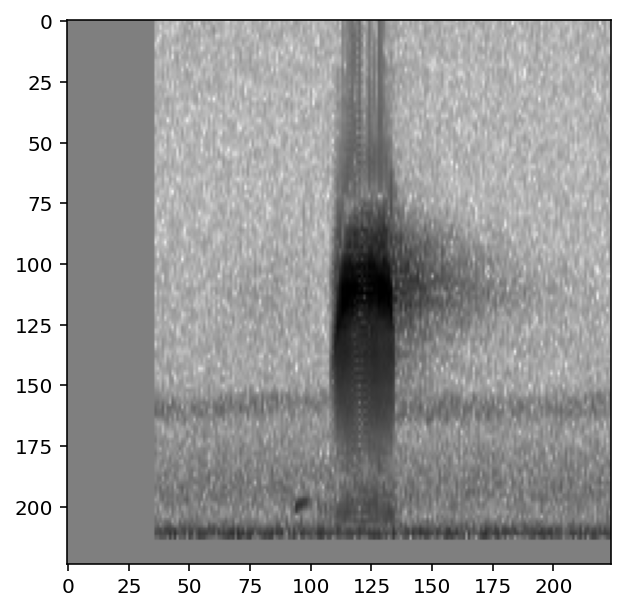

random affine off


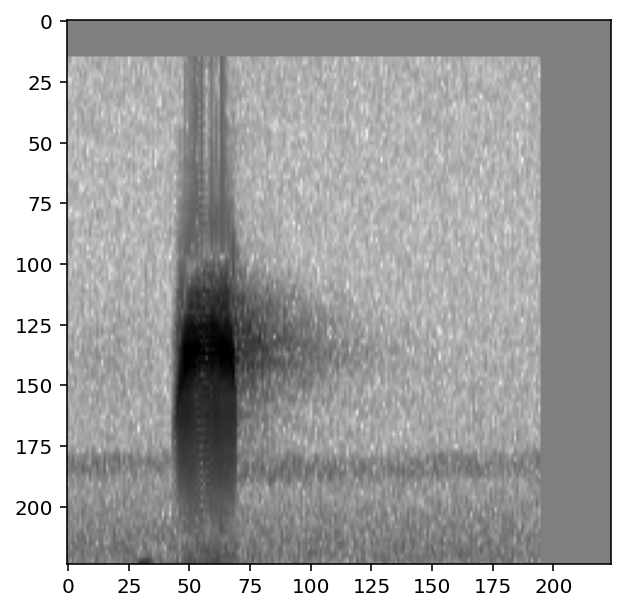

In [17]:
print('random affine on')
show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)

print('random affine off')
preprocessor.pipeline.random_affine.bypass = False
show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)

To view whether an individual Action in a pipeline is on or off, inspect its `bypass` attribute:

In [18]:
# The AudioLoader Action that is still on
preprocessor.pipeline.load_audio.bypass

False

In [19]:
# The frequency_mask Action that we turned off
preprocessor.pipeline.frequency_mask.bypass

True

## Modifying the pipeline
Sometimes, you may want to change the order or composition of the Preprocessor's pipeline. You can simply overwrite the `.pipeline` attribute, as long as the new pipeline is still a list of Action instances from the preprocessor's `.actions` ActionContainer. 

### Example: return Spectrogram instead of Tensor
Here's an example where we replace the pipeline with one that just loads audio and converts it to a Spectrogram, returning a Spectrogram instead of a Tensor:

In [20]:
preprocessor.pipeline

load_audio           Action calling <bound method Audio.from_file o...
random_trim_audio    Action calling <function trim_audio at 0x7fc4b...
trim_audio           Action calling <function trim_audio at 0x7fc4b...
to_spec              Action calling <bound method Spectrogram.from_...
bandpass             Action calling <function Spectrogram.bandpass ...
to_img               Action calling <function Spectrogram.to_image ...
time_mask            ### Bypassed Action calling <function time_mas...
frequency_mask       ### Bypassed Action calling <function frequenc...
add_noise            ### Bypassed Action calling <function tensor_a...
rescale              Action calling <function scale_tensor at 0x7fc...
random_affine        Action calling <function torch_random_affine a...
dtype: object

original pipeline:
Action calling <bound method Audio.from_file of <class 'opensoundscape.audio.Audio'>>
Action calling <function trim_audio at 0x7fc4b5d84430>
Action calling <function trim_audio at 0x7fc4b5d84430>
Action calling <bound method Spectrogram.from_audio of <class 'opensoundscape.spectrogram.Spectrogram'>>
Action calling <function Spectrogram.bandpass at 0x7fc4b30aa940>
Action calling <function Spectrogram.to_image at 0x7fc4b30aac10>
Action calling <function time_mask at 0x7fc4b5d96040>
Action calling <function frequency_mask at 0x7fc4b5d960d0>
Action calling <function tensor_add_noise at 0x7fc4b5d96160>
Action calling <function scale_tensor at 0x7fc4b5d91f70>
Action calling <function torch_random_affine at 0x7fc4b5d91e50>

new pipeline:
Action calling <bound method Audio.from_file of <class 'opensoundscape.audio.Audio'>>
Action calling <function trim_audio at 0x7fc4b5d84430>
Action calling <function trim_audio at 0x7fc4b5d84430>
Action calling <bound method Spectrogram.fro

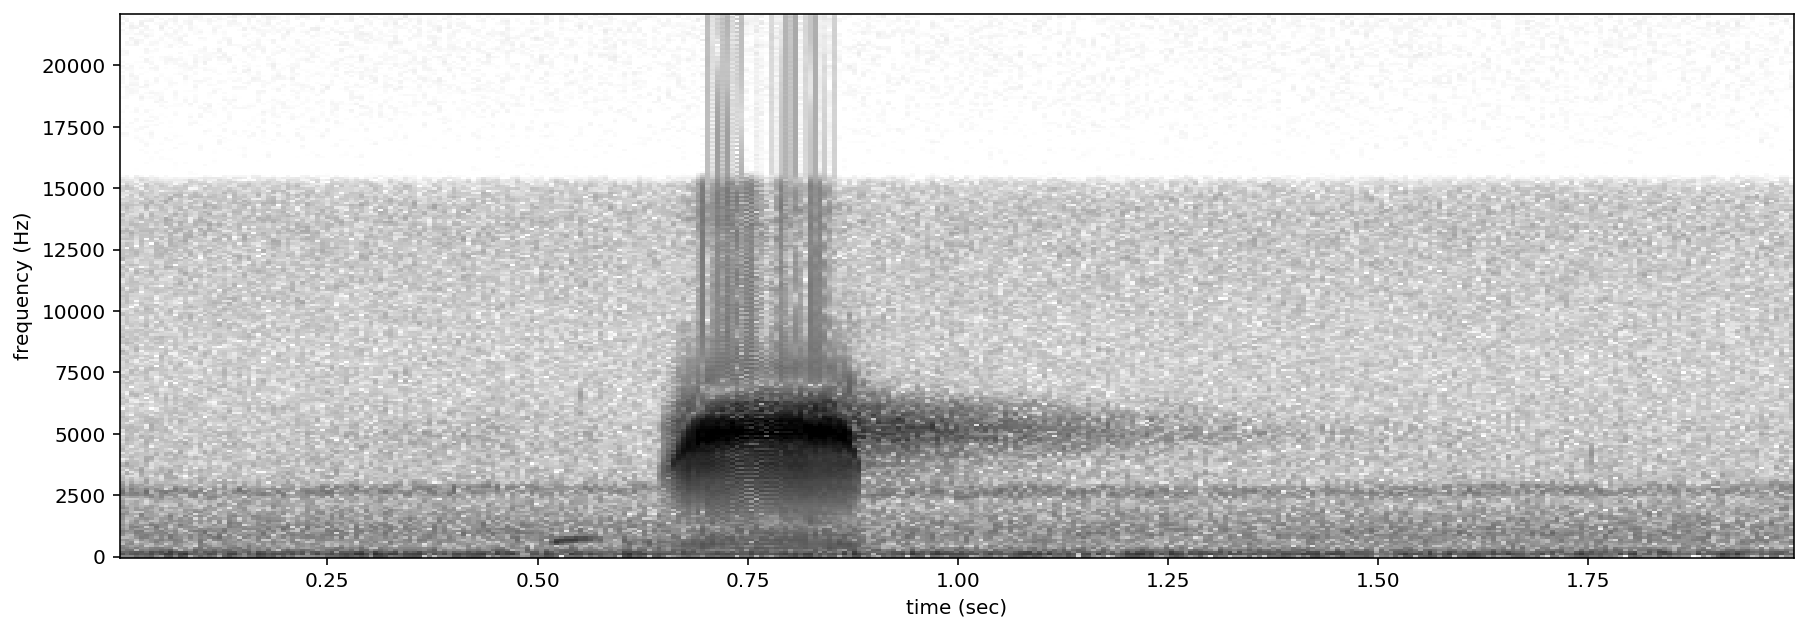

In [21]:
#initialize a preprocessor 
preprocessor = SpecPreprocessor(labels,2.0)
print('original pipeline:')
[print(p) for p in preprocessor.pipeline]

#overwrite the pipeline with a slice of the original pipeline
print('\nnew pipeline:')
preprocessor.pipeline = preprocessor.pipeline[0:4]
[print(p) for p in preprocessor.pipeline]

print('\nWe now have a preprocessor that returns Spectrograms instead of Tensors:')
print(type(preprocessor[0]['X']))
preprocessor[0]['X'].plot()

## Customizing a preprocessor

Below are various examples of how to modify parameters of the Actions 

### Modify the sample rate 
Resample all loaded audio to a specified rate during the load_audio action

In [22]:
preprocessor = SpecPreprocessor(labels,sample_duration=2)

preprocessor.pipeline.load_audio.set(sample_rate=24000)

### Modify spectrogram window length and overlap
(see Spectrogram.from_audio() for detailed documentation)

default parameters:


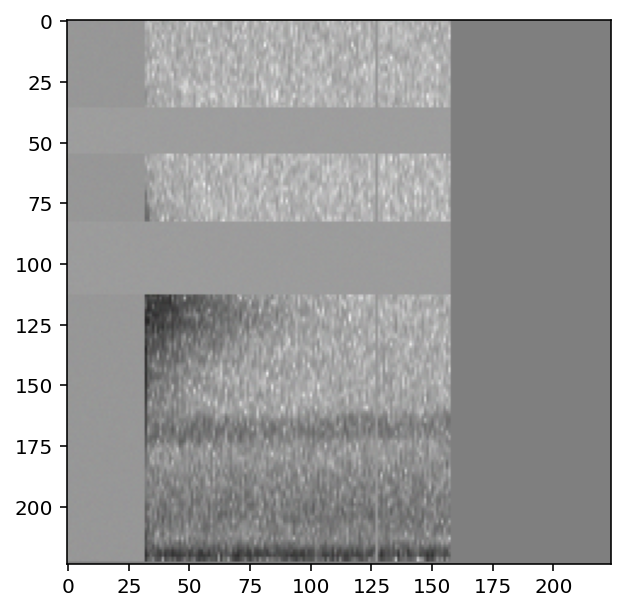

high time resolution, low frequency resolution:


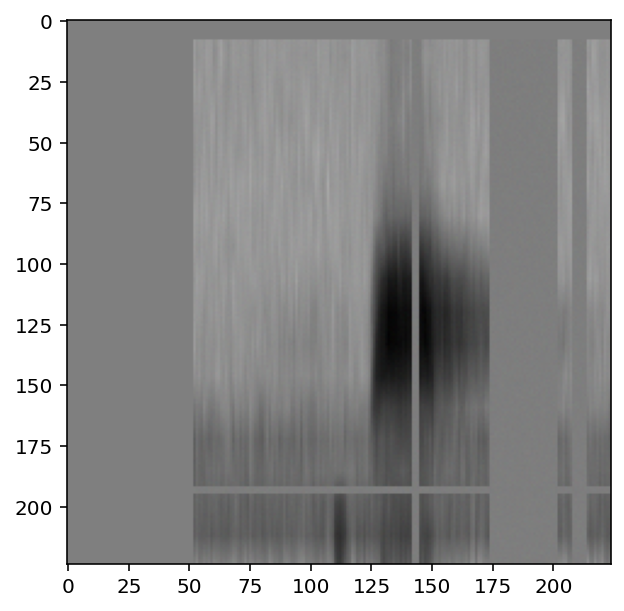

In [23]:
print('default parameters:')
show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)

print('high time resolution, low frequency resolution:')
preprocessor.pipeline.to_spec.set(window_samples=64,overlap_samples=32)

show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)

### Bandpass spectrograms
Trim spectrograms to a specified frequency range:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


default parameters:


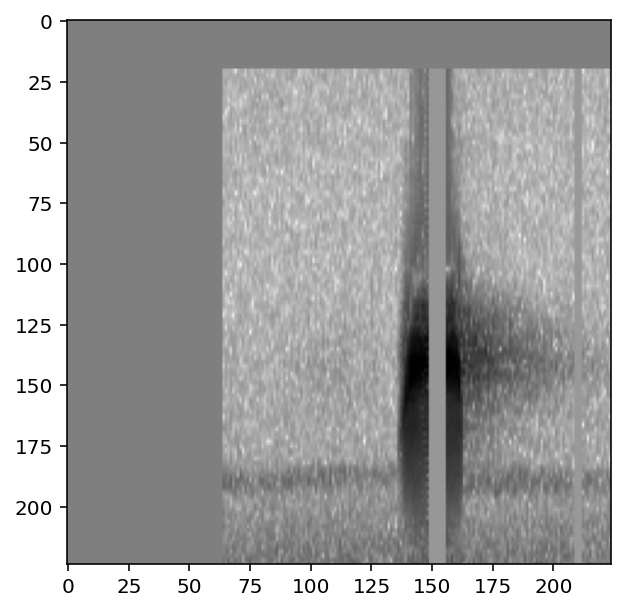

bandpassed to 2-4 kHz:


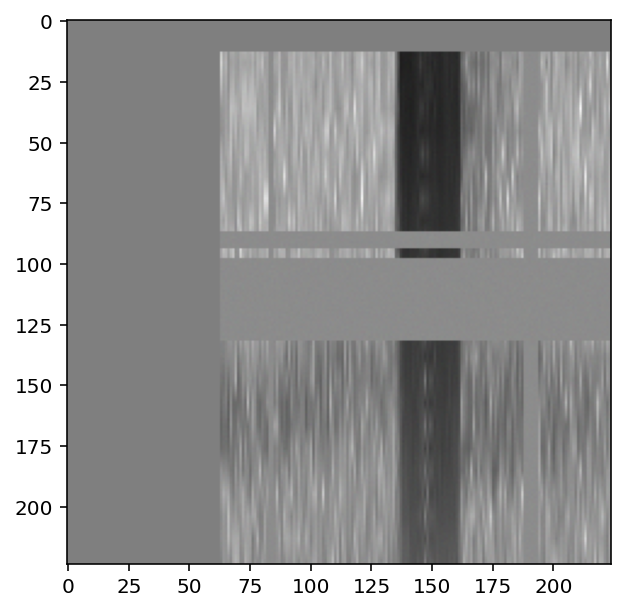

In [24]:
preprocessor = SpecPreprocessor(labels,2.0)

print('default parameters:')
show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)

print('bandpassed to 2-4 kHz:')
preprocessor.pipeline.bandpass.set(min_f=2000,max_f=4000)
show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)

### Change the output image

Change the shape of the output image 
- note that the shape argument expects (height, width), not (width, height) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


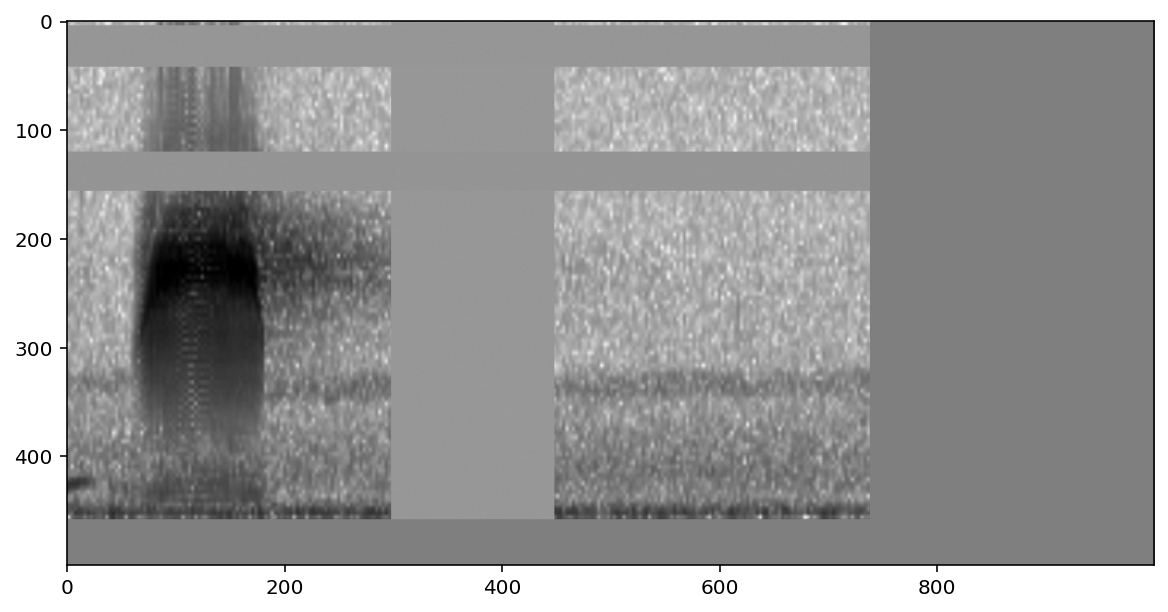

In [25]:
preprocessor = SpecPreprocessor(labels,2.0)
preprocessor.pipeline.to_img.set(shape=[500,1000])
show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)


This section describes:
* How to turn all augmentations on or off
* Examples of modifying augmentation parameters for standard augmentations
* Detailed descriptions of the useful "Overlay" augmentation

### Turn all augmentation on or off
augmentation is controlled by the `preprocessor.augmentation_on` boolean (aka True/False) variable. A CNN will internally manipulate this attribute to perform augmentations during training but not during validation or prediction.

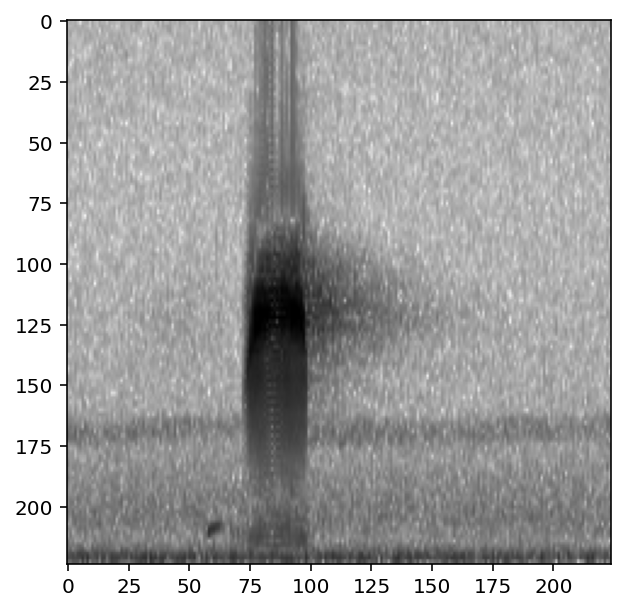

In [26]:
preprocessor = SpecPreprocessor(labels,2.0)

preprocessor.augmentation_on = False
show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


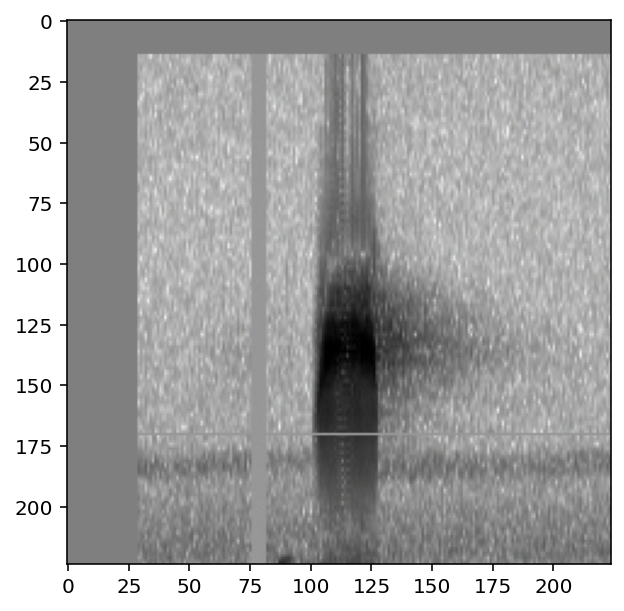

In [27]:
preprocessor.augmentation_on = True
show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)

### Modify augmentation parameters
`CnnPreprocessor` includes several augmentations with customizable parameters. Here we provide a couple of illustrative examples - see any action's documentation for details on how to use its parameters. 

In [28]:
preprocessor.pipeline

load_audio           Action calling <bound method Audio.from_file o...
random_trim_audio    Action calling <function trim_audio at 0x7fc4b...
trim_audio           Action calling <function trim_audio at 0x7fc4b...
to_spec              Action calling <bound method Spectrogram.from_...
bandpass             Action calling <function Spectrogram.bandpass ...
to_img               Action calling <function Spectrogram.to_image ...
time_mask            Action calling <function time_mask at 0x7fc4b5...
frequency_mask       Action calling <function frequency_mask at 0x7...
add_noise            Action calling <function tensor_add_noise at 0...
rescale              Action calling <function scale_tensor at 0x7fc...
random_affine        Action calling <function torch_random_affine a...
dtype: object

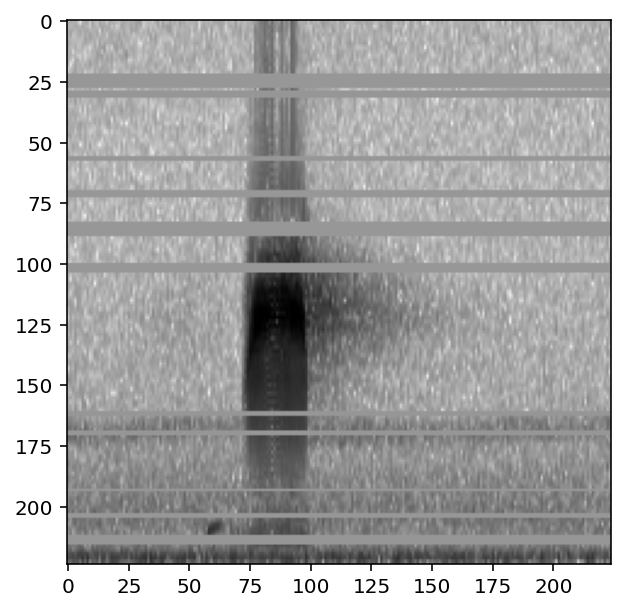

In [29]:
#initialize a preprocessor
preprocessor = SpecPreprocessor(labels,2.0)

#turn off augmentations other than overlay
preprocessor.pipeline.random_affine.bypass=True
preprocessor.pipeline.time_mask.bypass=True
preprocessor.pipeline.add_noise.bypass=True

# allow up to 20 horizontal masks, each spanning up to 0.1x the height of the image. 
preprocessor.pipeline.frequency_mask.set(max_width = 0.03, max_masks=20)
show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)

turn off frequency mask and turn on gaussian noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


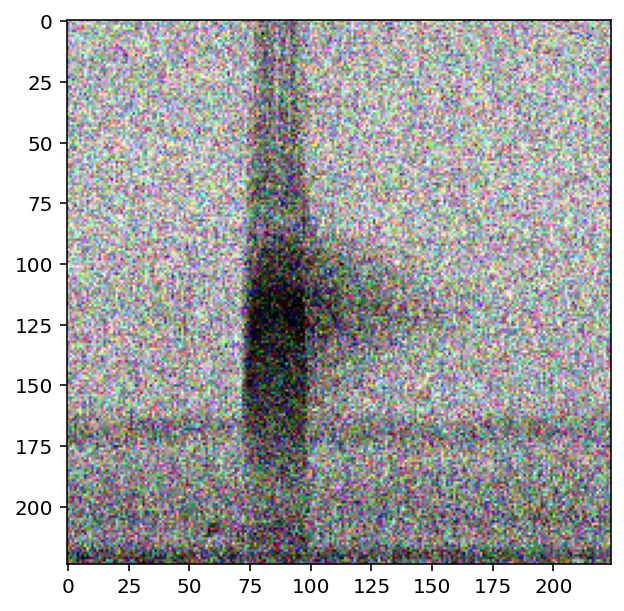

In [33]:
preprocessor.pipeline.add_noise.bypass = False
preprocessor.pipeline.frequency_mask.bypass =True

# increase the intensity of gaussian noise added to the image
preprocessor.pipeline.add_noise.set(std=0.2)
show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)

### remove an action by its name

In [34]:
preprocessor.remove_action('add_noise')
preprocessor.pipeline

load_audio           Action calling <bound method Audio.from_file o...
random_trim_audio    Action calling <function trim_audio at 0x7fc4b...
trim_audio           Action calling <function trim_audio at 0x7fc4b...
to_spec              Action calling <bound method Spectrogram.from_...
bandpass             Action calling <function Spectrogram.bandpass ...
to_img               Action calling <function Spectrogram.to_image ...
time_mask            ### Bypassed Action calling <function time_mas...
frequency_mask       ### Bypassed Action calling <function frequenc...
rescale              Action calling <function scale_tensor at 0x7fc...
random_affine        ### Bypassed Action calling <function torch_ra...
dtype: object

### add an action at a specific position
specify the action in the pipeline you want to insert before or after

In [35]:
from opensoundscape.preprocess.actions import Action, tensor_add_noise

preprocessor.insert_action( 
    action_index='add_noise_NEW', #give it a name
    action=Action(tensor_add_noise,std=0.01), #the action object
    after_key='to_img', #where to put it (can also use before_key=...)
)

In [36]:
preprocessor.pipeline

load_audio           Action calling <bound method Audio.from_file o...
random_trim_audio    Action calling <function trim_audio at 0x7fc4b...
trim_audio           Action calling <function trim_audio at 0x7fc4b...
to_spec              Action calling <bound method Spectrogram.from_...
bandpass             Action calling <function Spectrogram.bandpass ...
to_img               Action calling <function Spectrogram.to_image ...
add_noise_NEW        Action calling <function tensor_add_noise at 0...
time_mask            ### Bypassed Action calling <function time_mas...
frequency_mask       ### Bypassed Action calling <function frequenc...
rescale              Action calling <function scale_tensor at 0x7fc...
random_affine        ### Bypassed Action calling <function torch_ra...
dtype: object

it will complain if you use a non-unique index

In [38]:
from opensoundscape.preprocess.actions import Action, tensor_add_noise
import pytest

with pytest.raises(AssertionError): #make sure it raises an error, and catch it
    preprocessor.insert_action(
        action_index='add_noise_NEW', #using the same name as a currentaction will lead to an AssertionError
        action=Action(tensor_add_noise,std=0.01), #the action object
        after_key='to_img', #where to put it (can also use before_key=...)
    )

### Overlay augmentation
Overlay is a powerful Action that allows additional samples to be overlayed or blended with the original sample. 

The additional samples are chosen from the `overlay_df` that is provided to the preprocessor when it is initialized. The index of the `overlay_df` must be paths to audio files. The dataframe can be simply an index containing audio files with no other columns, or it can have the same columns as the sample dataframe for the preprocessor.

Samples for overlays are chosen based on their class labels, according to the parameter `overlay_class`:

- `None` - Randomly select any file from `overlay_df`
- `"different"` - Select a random file from `overlay_df` containing none of the classes this file contains
- specific class name - always choose files from this class

Samples can be drawn from dataframes in a few general ways (each is demonstrated below):

1. Using a separate dataframe where any sample can be overlayed (`overlay_class=None`)
2. Using the same dataframe as training, where the overlay class is "different," i.e., does not contain overlapping labels with the original sample
3. Using the same dataframe as training, where samples from a specific class are used for overlays

By default, the overlay Action does **not** change the labels of the sample it modifies. However, if you wish to add the labels from overlayed samples to the original sample's labels, you can set `update_labels=True` (see example below).

In [39]:
#initialize a preprocessor and provide a dataframe with samples to use as overlays
preprocessor = SpecPreprocessor(labels, 2.0, overlay_df=labels)

#remove augmentations other than overlay
for name in ['random_affine','time_mask','frequency_mask','add_noise']:
    preprocessor.remove_action(name)

#### Modify `overlay_weight`
We'll first overlay a random sample with 30% of the final mix coming from the overlayed sample (70% coming from the original) by using `overlay_weight=0.3`.

To demonstrate this, let's show what happens if we overlay samples from the "negative" class, resulting in the final sample having a higher or lower signal-to-noise ratio. By default, the overlay Action chooses a random file from the overlay dataframe. Instead, choose a sample from the class called `"present"` using the `overlay_class` parameter. 

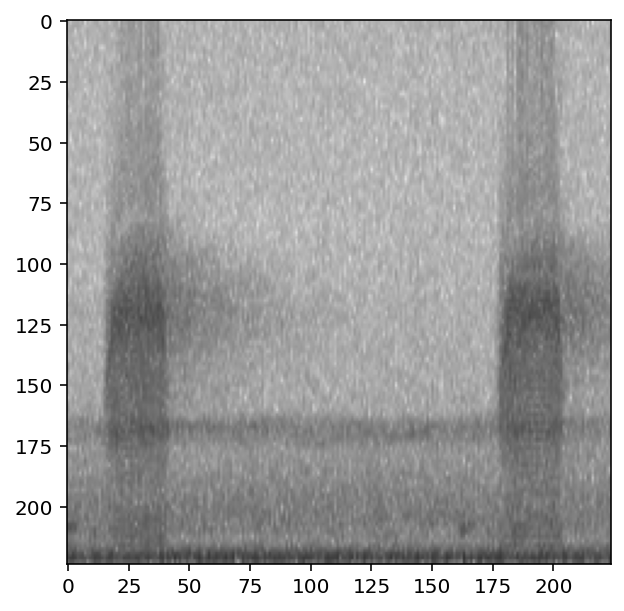

In [41]:
preprocessor.pipeline.overlay.set(
    overlay_class='present',
    overlay_weight=0.5
)
show_tensor(preprocessor[2]['X'],invert=True,transform_from_zero_centered=True)

Now use `overlay_weight=0.8` to increase the contribution of the overlayed sample (80%) compared to the original sample (20%). 

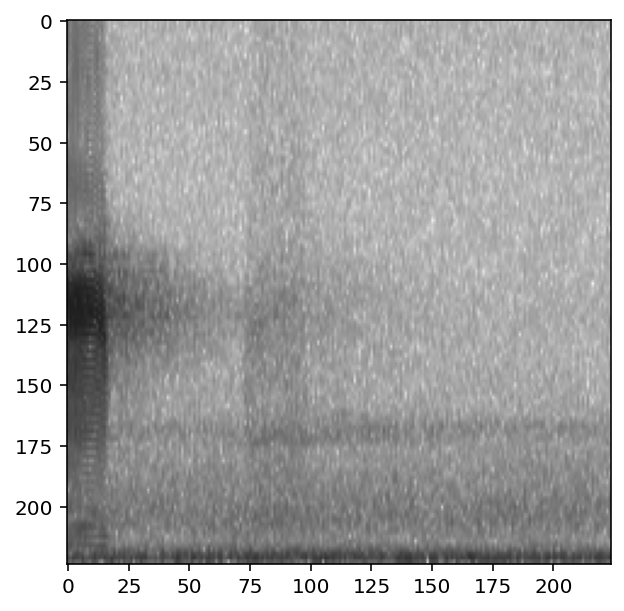

In [42]:
preprocessor.pipeline.overlay.set(overlay_weight=0.8)
show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)

#### Overlay samples from a specific class

As demonstrated above, you can choose a specific class to choose samples from. Here, instead, we choose samples from the "absent" class.

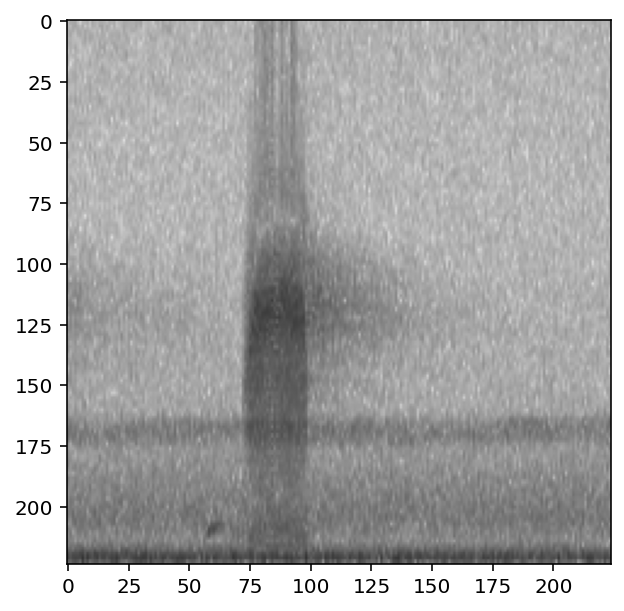

In [43]:
preprocessor.pipeline.overlay.set(
    overlay_class='absent',
    overlay_weight=0.4
)
show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)

#### Overlaying samples from any class
By default, or by specifying `overlay_class=None`, the overlay sample is chosen randomly from the overlay_df with no restrictions.

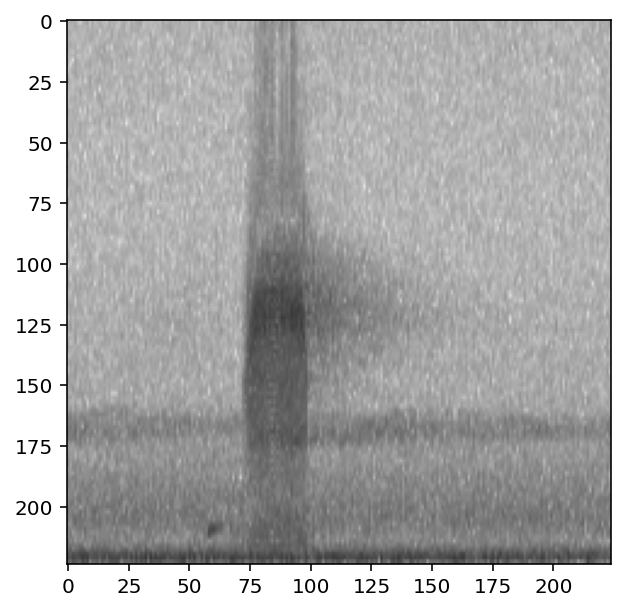

In [44]:
preprocessor.pipeline.overlay.set(overlay_class=None)
show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)

#### Overlaying samples from a "different" class
The `'different'` option for `overlay_class` chooses a sample to overlay that has non-overlapping labels with the original sample. 

In the case of this example, this has the same effect as drawing samples from the `"negative"` class a demonstrated above. In multi-class examples, this would draw from any of the samples not labeled with the class(es) of the original sample.

We'll again use `overlay_weight=0.8` to exaggerate the importance of the overlayed sample (80%) compared to the original sample (20%). 

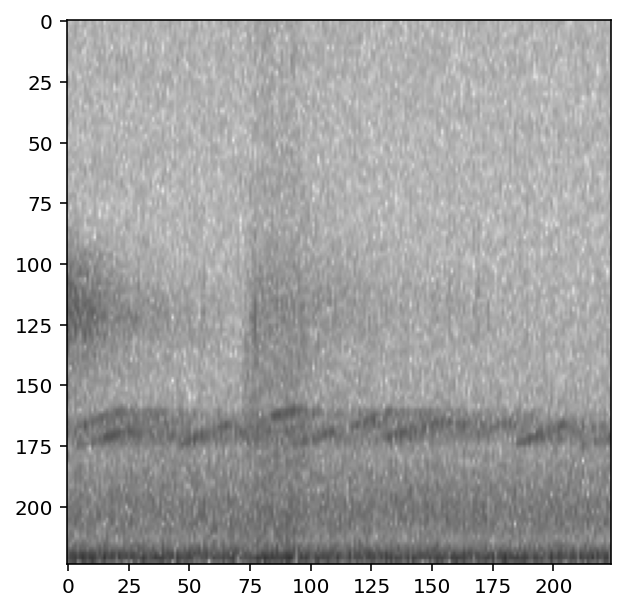

In [45]:
preprocessor.pipeline.overlay.set(update_labels=False,overlay_class='different',overlay_weight=0.8)
show_tensor(preprocessor[0]['X'],invert=True,transform_from_zero_centered=True)

#### Updating labels 
By default, the overlay Action does **not** change the labels of the sample it modifies. 

For instance, if the overlayed sample has labels [1,0] and the original sample has labels [0,1], the default behavior will return a sample with labels [0,1] not [1,1]. 

If you wish to add the labels from overlayed samples to the original sample's labels, you can set `update_labels=True`. 

In [46]:
print('default: labels do not update')
preprocessor.pipeline.overlay.set(update_labels=False,overlay_class='different')
print(f"\t resulting labels: {preprocessor[0]['y'].numpy()}")

print('Using update_labels=True')
preprocessor.pipeline.overlay.set(update_labels=True,overlay_class='different')
print(f"\t resulting labels: {preprocessor[0]['y'].numpy()}")


default: labels do not update
	 resulting labels: [1 0]
Using update_labels=True
	 resulting labels: [1 1]


This example is a single-target problem: the two classes represent "woodcock absent" and "woodcock present." Because the labels are mutually exclusive, labels [1,1] do not make sense. So, for this single-target problem, we would __not__ want to use `update_labels=True`, and it would probably make most sense to only overlay absent recordings, e.g., `overlay_class='absent'`.

## Creating a new Preprocessor class
If you have a specific augmentation routine you want to perform, you may want to create your own Preprocessor class rather than modifying an existing one. 


Your subclass might add a different set of Actions, define a different pipeline, or even override the `__getitem__` method of BasePreprocessor. 

Here's an example of a customized preprocessor that subclasses `AudioToSpectrogramPreprocessor` and creates a pipeline that depends on the `magic_parameter` input. 

In [47]:
from opensoundscape.preprocess.actions import Action, tensor_add_noise
class MyPreprocessor(SpecPreprocessor):
    """Child of AudioToSpectrogramPreprocessor with weird augmentation routine"""
    
    def __init__(
        self,
        df,
        magic_parameter,
        sample_duration,
        return_labels=True,
        out_shape=[224, 224,1],
    ):

        super(MyPreprocessor, self).__init__(
            df,
            sample_duration=sample_duration,
            out_shape=out_shape,
            return_labels=return_labels,
        )

        for i in range(magic_parameter):
            action = Action(tensor_add_noise, std=0.1*magic_parameter)
            self.insert_action(f'noise_{i}',action)

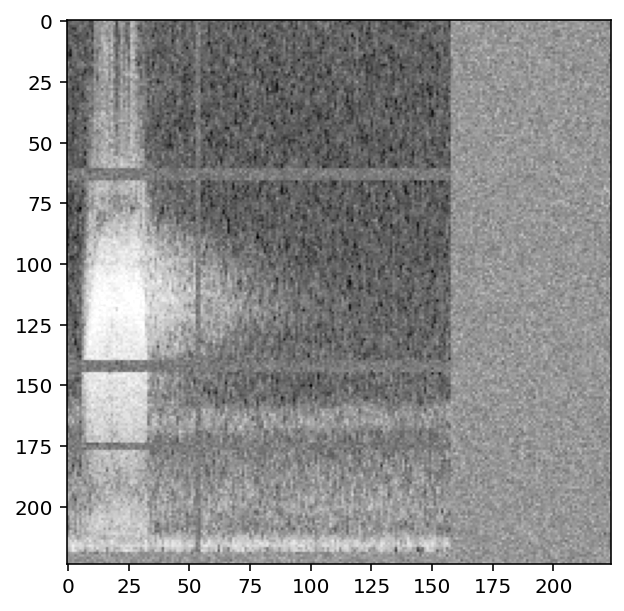

In [51]:
p = MyPreprocessor(labels, sample_duration=2.0, magic_parameter=1)
show_tensor(p[0]['X'],invert=True,transform_from_zero_centered=True)

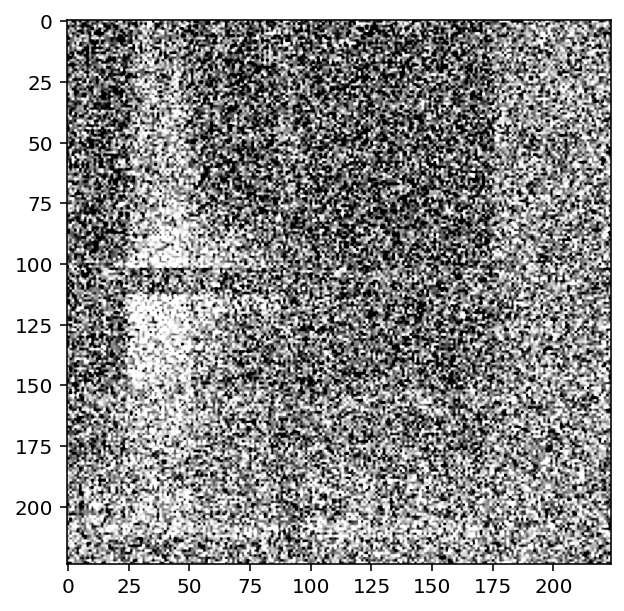

In [52]:
p = MyPreprocessor(labels, sample_duration=2.0, magic_parameter=4)
show_tensor(p[0]['X'],invert=True,transform_from_zero_centered=True)

## Defining new Actions
You can usually define a new action simply by passing a method to Action(). However, you can also write a subclass of Action for more advanced use cases - especially if you need inputs other than the sample, such as labels. 

### using additional input in an Action

The following additional variables can be requested by an action, and will be passed from the pipeline when the action is run:
```
    "_path": audio file path
    "_labels": row of pd.DataFrame with 0/1 labels for each class (pd.Series)
    "_start_time": start time of clip within longer audio file, if splitting long files into clips during preprocessing
    "_sample_duration": sample_duration of clip in seconds
    "_pipeline": a copy of the preprocessor's pipeline itself
```

In [73]:
from opensoundscape.preprocess.actions import Action

def my_action_fn(x, _labels,threshold=0.1):
    if _labels[0]==1:
        samples = np.array([0 if np.abs(s)<threshold else s for s in audio.samples])
        x = Audio(samples, audio.sample_rate)
    return x

class AudioGate(Action):
    """Replace audio samples below a threshold with 0, but only if label[0]==1
    
    Audio in, Audio out
    
    Args: 
        threshold: sample values below this will become 0
    """

    def __init__(self, **kwargs):
        super(AudioGate, self).__init__(my_action_fn,extra_args=['_labels'],**kwargs)

Test it out:

histogram of samples


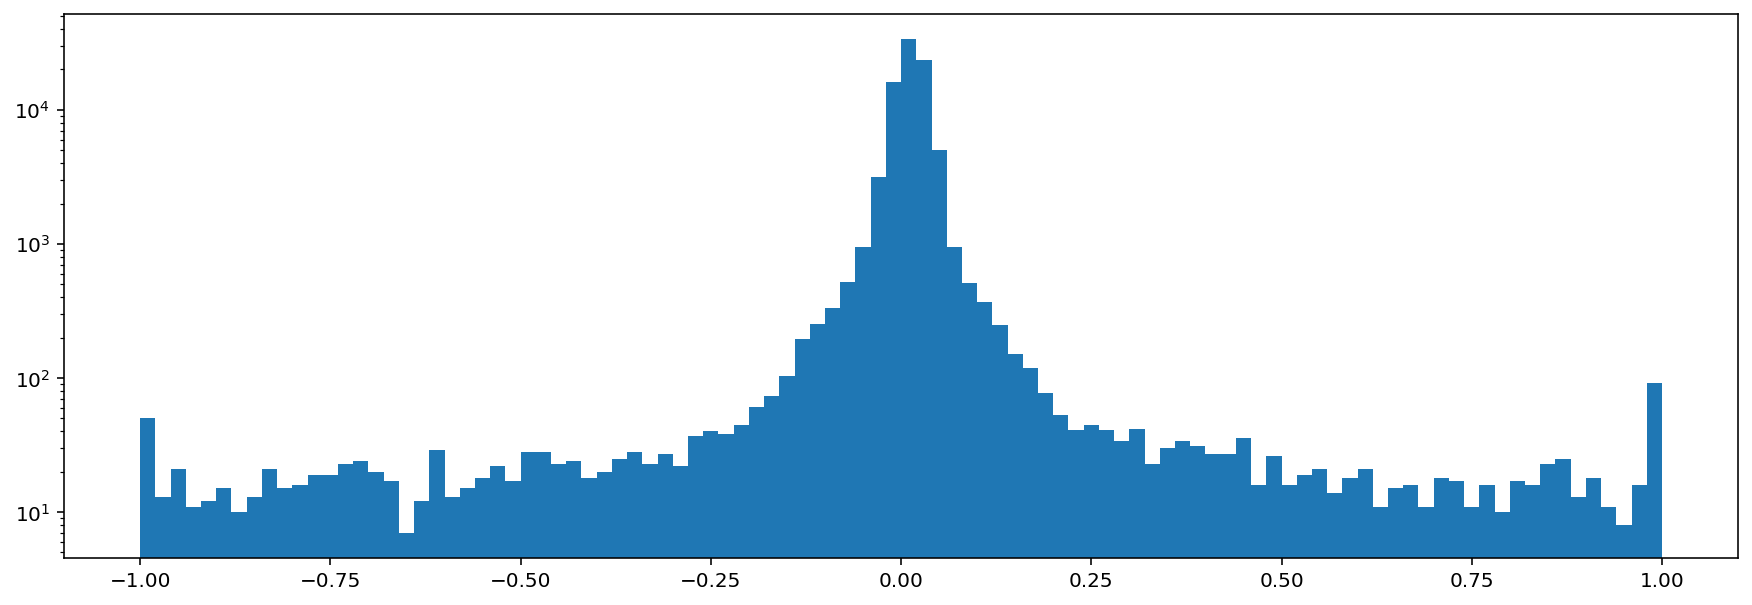

histogram of samples after audio gate


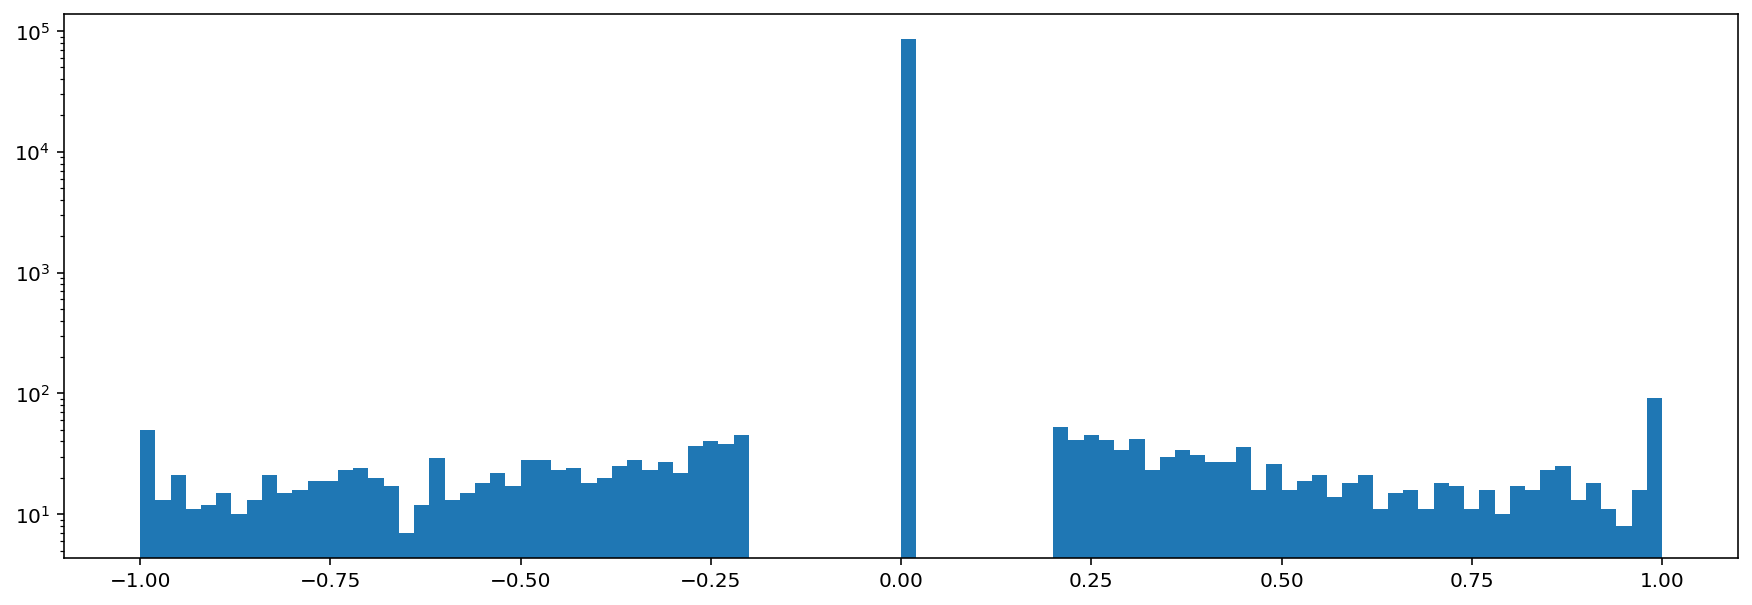

histogram of samples after audio gate, when labels[0]==0


[]

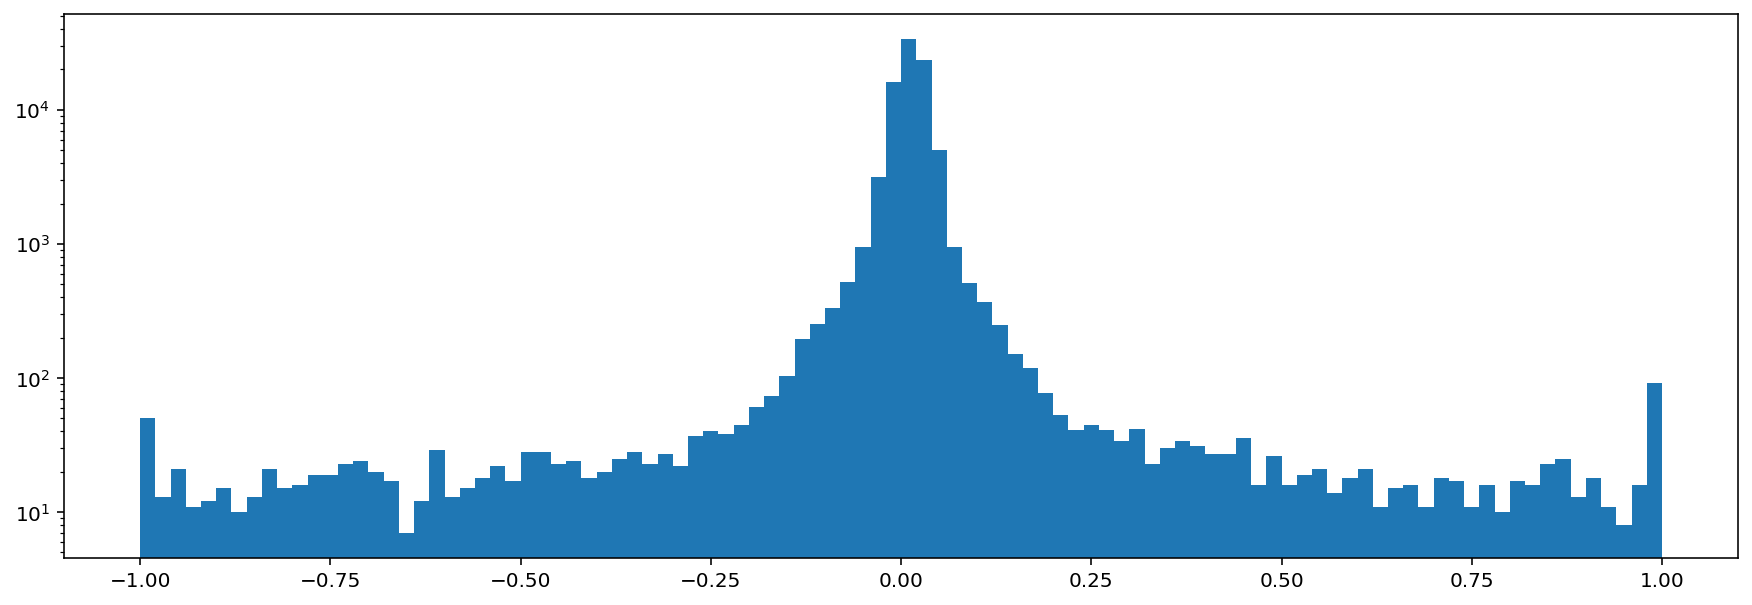

In [75]:
from opensoundscape.audio import Audio

gate_action = AudioGate(threshold=0.2)

print('histogram of samples')
audio = Audio.from_file('./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav')
_ = plt.hist(audio.samples,bins=100)
plt.semilogy()
plt.show()

print('histogram of samples after audio gate')
audio_gated = gate_action.go(audio,_labels={0:1,1:0})
_ = plt.hist(audio_gated.samples,bins=100)
plt.semilogy()
plt.show()

print('histogram of samples after audio gate, when labels[0]==0')
audio_gated = gate_action.go(audio,_labels={0:0,1:1})
_ = plt.hist(audio_gated.samples,bins=100)
plt.semilogy()

Clean up files created during this tutorial:

In [76]:
import shutil
shutil.rmtree('./woodcock_labeled_data')